## Fashion Data EDA

In [192]:
import pandas as pd
import numpy as np
import gzip
import math
import matplotlib.pyplot as plt
import seaborn as sns
import string
from collections import defaultdict
import regex as re
from dateutil.parser import parse

In [169]:
runway_data = 'renttherunway_final_data.json.gz'
modcloth_data = 'modcloth_final_data.json.gz'

In [170]:
def parseData(fname):
    '''
    Parse in the data from the file path/link
    '''
    total = 0
    for l in gzip.open(fname):
        try:
            yield eval(l)
        except NameError:
            total += 1
            print(f"Scrapping Data, Null Entry: {total}")

In [171]:
runway = list(parseData(runway_data))
modcloth = list(parseData(modcloth_data)) #could we use modcloth as a test set?

Scrapping Data, Null Entry: 1
Scrapping Data, Null Entry: 2
Scrapping Data, Null Entry: 3
Scrapping Data, Null Entry: 4
Scrapping Data, Null Entry: 5
Scrapping Data, Null Entry: 6
Scrapping Data, Null Entry: 7
Scrapping Data, Null Entry: 8
Scrapping Data, Null Entry: 9
Scrapping Data, Null Entry: 10
Scrapping Data, Null Entry: 11
Scrapping Data, Null Entry: 12
Scrapping Data, Null Entry: 13
Scrapping Data, Null Entry: 14
Scrapping Data, Null Entry: 15
Scrapping Data, Null Entry: 16
Scrapping Data, Null Entry: 17
Scrapping Data, Null Entry: 18
Scrapping Data, Null Entry: 19
Scrapping Data, Null Entry: 20
Scrapping Data, Null Entry: 21
Scrapping Data, Null Entry: 22
Scrapping Data, Null Entry: 23
Scrapping Data, Null Entry: 24
Scrapping Data, Null Entry: 25
Scrapping Data, Null Entry: 26
Scrapping Data, Null Entry: 27
Scrapping Data, Null Entry: 28
Scrapping Data, Null Entry: 29
Scrapping Data, Null Entry: 30
Scrapping Data, Null Entry: 31
Scrapping Data, Null Entry: 32
Scrapping Data, N

### Cleaning

In [172]:
def bustSplitter(s):
    '''
    Split our bust measurement into measurement and cup size.
    '''
    bust = s[:2]
    cup = s[2:]
    return int(bust), cup

In [173]:
#how many entries are missing bust size
unusable_data = 0
columns = set(list(runway[0].keys()))
for review in runway:
    if len(set(list(review.keys())).intersection(columns)) < len(columns):
        unusable_data += 1
unusable_data

46081

In [174]:
#split bust into measurement and cup size
data = []
for review in runway:
    if len(set(list(review.keys())).intersection(columns)) < len(columns): 
        #if they're missing a column
        continue
    review['bust'], review['cup'] = bustSplitter(review['bust size']) 
    data.append(review)

In [175]:
len(data), len(runway) #dropped around 2000 entries

(146381, 192462)

- To Do for Cleaning
- find max/min rating
- clean review text

In [176]:
data[0]

{'fit': 'fit',
 'user_id': '420272',
 'bust size': '34d',
 'item_id': '2260466',
 'weight': '137lbs',
 'rating': '10',
 'rented for': 'vacation',
 'review_text': "An adorable romper! Belt and zipper were a little hard to navigate in a full day of wear/bathroom use, but that's to be expected. Wish it had pockets, but other than that-- absolutely perfect! I got a million compliments.",
 'body type': 'hourglass',
 'review_summary': 'So many compliments!',
 'category': 'romper',
 'height': '5\' 8"',
 'size': 14,
 'age': '28',
 'review_date': 'April 20, 2016',
 'bust': 34,
 'cup': 'd'}

In [177]:
for d in data:
    d['weight'] = int(re.sub("[^0-9]", "", d['weight']))
    d['rating'] = int(d['rating'])
    d['size'] = int(d['size'])
    d['age'] = int(d['age'])
    d['review_date'] = parse(d['review_date'])
    heights = [int(num.strip('\'').strip('\"')) for num in d['height'].split()]
    d['height'] = (heights[0] * 12) + heights[1]

In [182]:
data[0]

{'fit': 'fit',
 'user_id': '420272',
 'bust size': '34d',
 'item_id': '2260466',
 'weight': 137,
 'rating': 10,
 'rented for': 'vacation',
 'review_text': "An adorable romper! Belt and zipper were a little hard to navigate in a full day of wear/bathroom use, but that's to be expected. Wish it had pockets, but other than that-- absolutely perfect! I got a million compliments.",
 'body type': 'hourglass',
 'review_summary': 'So many compliments!',
 'category': 'romper',
 'height': 68,
 'size': 14,
 'age': 28,
 'review_date': datetime.datetime(2016, 4, 20, 0, 0),
 'bust': 34,
 'cup': 'd'}

### EDA

In [184]:
fashion_df = pd.DataFrame(data)

In [230]:
fashion_df[['weight', 'height', 'rating', 'bust', 'size', 'age']].describe()
#looks like rating is 5 stars, but prof multlied it by two to include half star ratings
#why do we have ages of 0? sizes of 0? are there people who weigh 50lbs?

,weight,height,rating,bust,size,age
count,146381.000000,146381.000000,146381.000000,146381.000000,146381.000000,146381.000000
mean,137.209870,65.263053,9.081985,34.110738,11.437919,34.089800
std,21.540182,2.659230,1.437853,1.701981,7.826784,8.113217
min,50.000000,54.000000,2.000000,28.000000,0.000000,0.000000
25%,123.000000,63.000000,8.000000,32.000000,4.000000,29.000000
50%,135.000000,65.000000,10.000000,34.000000,9.000000,32.000000
75%,148.000000,67.000000,10.000000,36.000000,16.000000,37.000000
max,300.000000,78.000000,10.000000,48.000000,58.000000,117.000000


<AxesSubplot:xlabel='weight', ylabel='Density'>

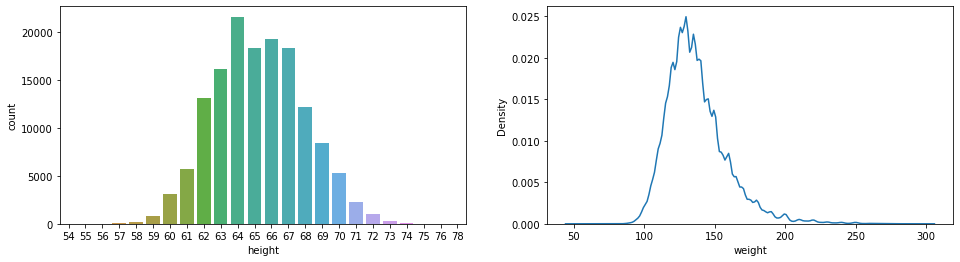

In [227]:
fig, axes = plt.subplots(ncols = 2, figsize = (16, 4))
sns.countplot(data = fashion_df, x = 'height', ax = axes[0])
sns.kdeplot(data = fashion_df, x = 'weight', ax = axes[1])

<AxesSubplot:xlabel='rating', ylabel='count'>

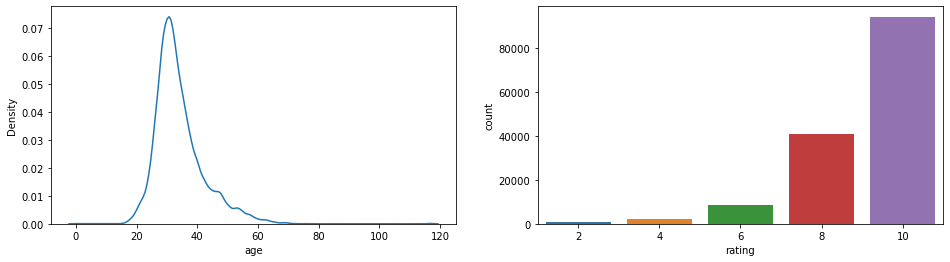

In [233]:
fig, axes = plt.subplots(ncols = 2, figsize = (16, 4))
sns.kdeplot(data = fashion_df, x = 'age', ax = axes[0])
sns.countplot(data = fashion_df, x = 'rating', ax = axes[1])

<AxesSubplot:xlabel='fit', ylabel='count'>

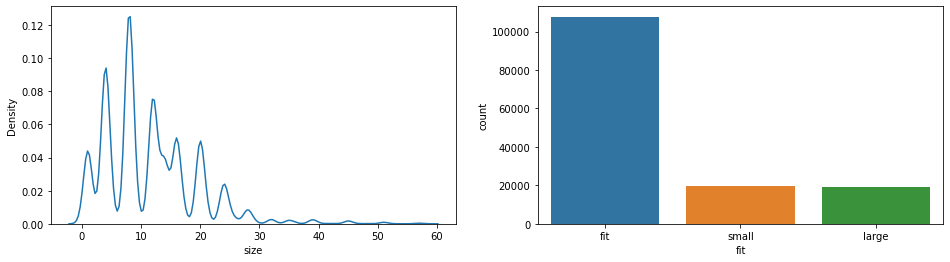

In [237]:
fig, axes = plt.subplots(ncols = 2, figsize = (16, 4))
sns.kdeplot(data = fashion_df, x = 'size', ax = axes[0])
sns.countplot(data = fashion_df, x = 'fit', ax = axes[1])

<AxesSubplot:xlabel='body type', ylabel='count'>

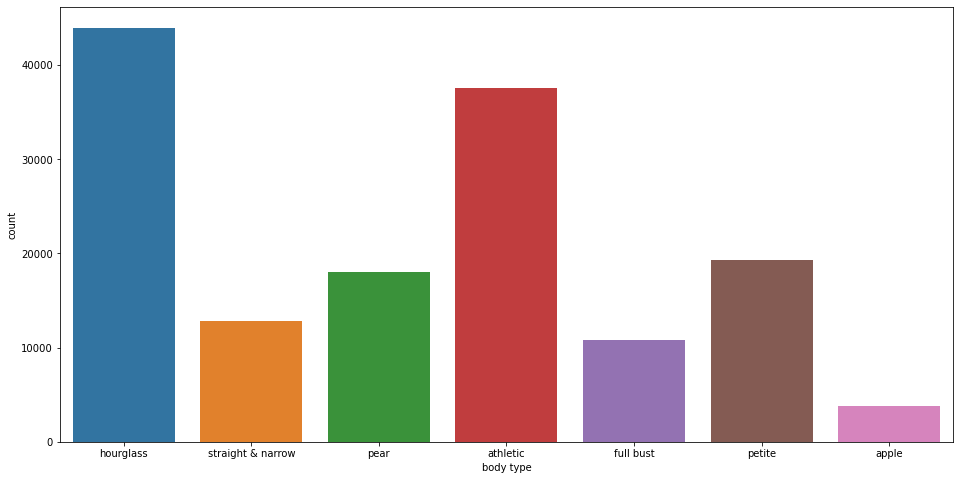

In [241]:
fig, axes = plt.subplots(ncols = 1, figsize = (16, 8))
sns.countplot(data = fashion_df, x = 'body type', ax = axes)

<AxesSubplot:xlabel='bust', ylabel='count'>

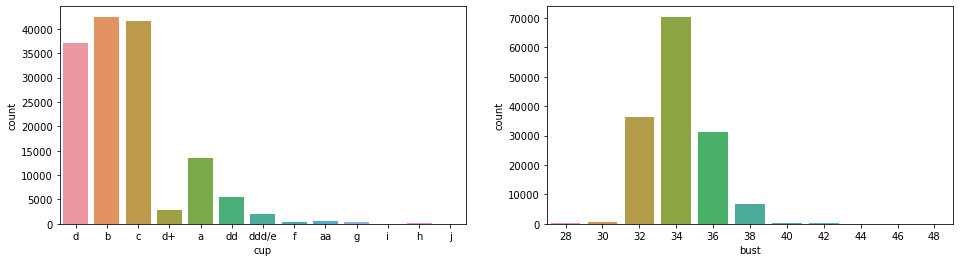

In [220]:
fig, axes = plt.subplots(ncols = 2, figsize = (16, 4))
sns.countplot(data = fashion_df, x = 'cup', ax = axes[0])
sns.countplot(data = fashion_df, x = 'bust', ax = axes[1])